In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

## Dataset Aggregation

In [2]:
trips = pd.read_csv('trips_raw_data.csv')

In [3]:
trips.head()

,Unnamed: 0,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,...,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,58,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
1,59,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
2,60,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St W / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
3,61,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
4,62,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St/Queens Quay(Billy Bishop Airport),7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN


In [4]:
trips['Start Time'] = pd.DatetimeIndex(trips['Start Time'])

Our model will be focused on predicting BikeShare trips for a "normal" year. Whether that future years represent a normal year is unknown, but we also can't assume any of the trends in 2020 will continue.

We will limit the model to look only at 2019 data, from January 1st to December 31st.

In [5]:
trips = trips[trips['Start Time'].dt.year == 2019]

## Filling Missing Values

In [6]:
trips_temp = trips[['Start Time','Temp (°C)']]

trips_temp['date'] = trips['Start Time'].dt.date
trips_temp['hour'] = trips['Start Time'].dt.hour

trips_temp = trips_temp[['date', 'hour','Temp (°C)']]

trips_temp = trips_temp.drop_duplicates(['date', 'hour'])
trips_temp[trips_temp['Temp (°C)'].isna()].groupby('date').count()
trips_temp = trips_temp[['date', 'hour','Temp (°C)']]

trips_temp[trips_temp['Temp (°C)'].isna()].groupby('date').count()

,hour,Temp (°C)
date,,
2019-03-20,1,0
2019-05-22,8,0
2019-05-23,8,0
2019-05-24,12,0
2019-06-01,1,0
2019-06-02,19,0
2019-06-03,16,0
2019-06-04,13,0
2019-06-05,3,0


In [7]:
trips_wind = trips[['Start Time','Wind Spd (km/h)']]

trips_wind['date'] = trips['Start Time'].dt.date
trips_wind['hour'] = trips['Start Time'].dt.hour

trips_wind = trips_wind[['date', 'hour','Wind Spd (km/h)']]

trips_wind = trips_wind.drop_duplicates(['date', 'hour'])
trips_wind[trips_wind['Wind Spd (km/h)'].isna()].groupby('date').count()
trips_wind = trips_wind[['date', 'hour','Wind Spd (km/h)']]

trips_wind[trips_wind['Wind Spd (km/h)'].isna()].groupby('date').count()

,hour,Wind Spd (km/h)
date,,
2019-03-19,2,0
2019-03-20,1,0
2019-05-17,4,0
2019-05-22,8,0
2019-06-12,1,0
2019-07-04,3,0
2019-07-18,4,0


In [8]:
weather_avg = trips
weather_avg['month'] = trips['Start Time'].dt.month
weather_avg['hour'] = trips['Start Time'].dt.hour
weather_avg = weather_avg.groupby(['month', 'hour']).agg({'Temp (°C)':'mean', 'Wind Spd (km/h)':'mean'}).reset_index()

In [9]:
weather_avg

,month,hour,Temp (°C),Wind Spd (km/h)
0,1,0,-1.551848,18.861396
1,1,1,-1.297456,20.106518
2,1,2,-1.407176,20.717593
3,1,3,-1.961066,22.918033
4,1,4,-2.515432,23.283951
...,...,...,...,...
283,12,19,1.207036,17.340282
284,12,20,1.265502,17.313850
285,12,21,1.156430,16.766685
286,12,22,1.205814,16.363543


# Feature Engineering

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
def aggregate_trips(df):
    df['Start Time'] = df['Start Time'].dt.floor('H')
    
    df_hourly = df.groupby('Start Time').agg({'Trip Id':'count', 'Weather':'first',
                                              'Wind Spd (km/h)': 'first', 'Temp (°C)': 'first'})
    df_hourly = df_hourly.reset_index()
    
    for index in df_hourly[df_hourly['Temp (°C)'].isna()].index:
        mon = df_hourly.loc[index, 'Start Time'].month
        hr = df_hourly.loc[index, 'Start Time'].hour
        avg_temp = weather_avg[(weather_avg['month'] == mon) & (weather_avg['hour'] == hr)].iloc[0,2]

        df_hourly.loc[index, 'Temp (°C)'] = avg_temp
        
    for index in df_hourly[df_hourly['Wind Spd (km/h)'].isna()].index:
        mon = df_hourly.loc[index, 'Start Time'].month
        hr = df_hourly.loc[index, 'Start Time'].hour
        avg_wind = weather_avg[(weather_avg['month'] == mon) & (weather_avg['hour'] == hr)].iloc[0,2]


        df_hourly.loc[index, 'Wind Spd (km/h)'] = avg_wind
    
    df_hourly = df_hourly.rename(columns = {'Trip Id': 'Trips', 'Wind Spd (km/h)':'Wind', 'Temp (°C)': 'Temp'})
    
    return df_hourly

In [31]:
trips_agg = aggregate_trips(trips)

In [32]:
train, test = train_test_split(trips_agg, train_size=0.7, 
                               test_size=0.3, random_state=0)
val, test = train_test_split(test, train_size=0.5,
                             test_size=0.5, random_state=0)

In [39]:
trips_agg.head()

,Start Time,Trips,Weather,Wind,Temp
0,2019-01-01 00:00:00-05:00,20,"Rain,Fog",11.0,4.3
1,2019-01-01 01:00:00-05:00,30,"Rain,Fog",4.0,5.1
2,2019-01-01 02:00:00-05:00,20,"Rain,Fog",28.0,5.9
3,2019-01-01 03:00:00-05:00,13,NaN,34.0,3.3
4,2019-01-01 04:00:00-05:00,7,NaN,28.0,2.8


## Chosen Parameters

* Wind Speed
* Hour of Day
* Month
* Weekend vs Weekday - if weekend or statutory holiday, then 1, otherwise 0
* Temperature - binned with this distribution [-30,0,10,20,30,40]
* Precipitation - if precipitation present, then 1, otherwise 0

In [14]:
def weather_features(df):
    
    #df['Temp'] = np.digitize(df.loc[:, 'Temp'], [-40,0,10,20,30,40])
    df['Weather'] = np.where(df['Weather'].isna(), 0, 1)
    
    return df

In [15]:
!pip install holidays

In [16]:
from datetime import date
import holidays

In [17]:
on_hol = holidays.CA(prov = 'ON', years = 2019)
for i in on_hol:
    print(i)

2019-01-01
2019-02-18
2019-04-19
2019-05-20
2019-07-01
2019-08-05
2019-09-02
2019-10-14
2019-12-25
2019-12-26


In [18]:
def temporal_features(df):
    
    df['Month'] = df['Start Time'].dt.month
    df['Hour'] = df['Start Time'].dt.hour
    df['dow'] = np.where(df['Start Time'].dt.dayofweek > 4, 1, 0)
    df['dow'] = np.where(df['Start Time'].dt.date.isin(on_hol), 1, 0)
    
    return df

In [44]:
from sklearn.preprocessing import MinMaxScaler 

def process_data(df, cat_features, scaled_features, binary_features):
    
    df = weather_features(df)
    df = temporal_features(df)
    
    df = df.drop(columns = ['Start Time'])
    y = df['Trips']
    
    if binary_features != None:
        binary = df[binary_features] 
    else:
        binary = None
    
    if (scaled_features != None) & (cat_features != None):
        categoricals = [pd.get_dummies(df[s], prefix=s, drop_first=False) for s in cat_features]
        scaler = MinMaxScaler()
        scaler.fit(df[scaled_features])

        
        scaled = df[scaled_features]

        scaled.iloc[:, :] = scaler.transform(scaled) 
        x = pd.concat([scaled] + [binary] + categoricals, axis=1)
    elif (scaled_features == None) & (cat_features != None):    
        categoricals = [pd.get_dummies(df[s], prefix=s, drop_first=False) for s in cat_features]
        x = pd.concat(categoricals + [binary], axis=1)
        
    elif (scaled_features != None) & (cat_features == None):
            

        scaler = MinMaxScaler()
        scaler.fit(df[scaled_features])

        scaled = df[scaled_features]

        scaled.iloc[:, :] = scaler.transform(scaled) 
        x = pd.concat([scaled] + [binary], axis=1)
        
    else:
        x = pd.concat([binary], axis=1)
        

    
    return x, y

# Model Fitting
In this section, we will be using linear regression model to predict ridership 

First defining the RMSE calculation

In [45]:
def rmse(errors):
    return np.sqrt(np.sum(errors ** 2)/len(errors))

## Constant RMSE
Next, we will establish a baseline model to compare, which will be our constant RMSE 

In [46]:
constant_rmse = rmse(val['Trips'] - val['Trips'].mean())
print(constant_rmse)

322.95655430558554


## Simple RMSE
Once a baseline is established, we will now create a simple model that predicts trips with only one variable.

In [47]:
x_train_simple, y_train_simple = process_data(train, None, ['Wind'], None)

x_val_simple, y_val_simple = process_data(val, None, ['Wind'], None)

In [48]:
from sklearn.linear_model import LinearRegression

simple_model = LinearRegression(fit_intercept=True)

simple_model.fit(x_train_simple, y_train_simple)
y_predicted = simple_model.predict(x_val_simple)

simple_rmse = rmse(y_predicted - y_val_simple)
print(simple_rmse)

322.49818371084285


Checking the estimated coefficient for the model, for this case there should be only one 

In [640]:
cdf = pd.DataFrame(simple_model.coef_, x_train_simple.columns, columns=['Coefficients'])
cdf

,Coefficients
Wind,-80.858185


We can see that there is a slight improvement for the RMSE but still not ideal

## Linear RMSE
Now we will derive a linear regression model using all the features provided above 

In [74]:
x_train, y_train = process_data(train, ['Hour', 'Month'], ['Wind','Temp'], ['dow', 'Weather'])
x_val, y_val = process_data(val, ['Hour', 'Month'], ['Wind','Temp'], ['dow', 'Weather'])

In [75]:
linear_model = LinearRegression(fit_intercept=True)

linear_model.fit(x_train, y_train)

y_predicted = linear_model.predict(x_val)

linear_rmse = rmse(y_predicted - y_val)
print(linear_rmse)

228.6305016263353


In [51]:
cdf = pd.DataFrame(linear_model.coef_, x_train.columns, columns=['Coefficients'])
cdf.transpose()

,Wind,Temp,dow,Weather,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Coefficients,-41.950296,414.615206,-148.755323,7.266882e+13,-2.518294e+13,-2.518294e+13,-2.518294e+13,-2.518294e+13,-2.518294e+13,-2.518294e+13,...,-4.748588e+13,-4.748588e+13,-4.748588e+13,-4.748588e+13,-4.748588e+13,-4.748588e+13,-4.748588e+13,-4.748588e+13,-4.748588e+13,-4.748588e+13


<AxesSubplot:>

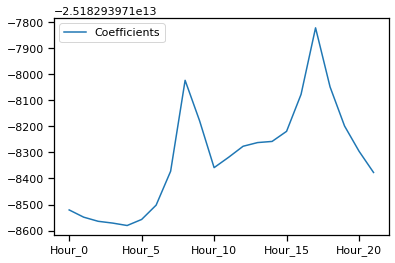

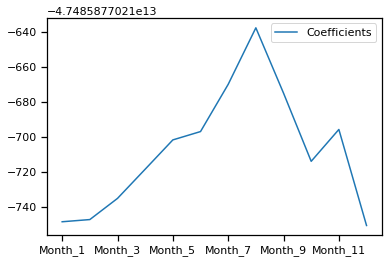

In [52]:
cdf.iloc[4:26,:].plot()
cdf.iloc[28:41,:].plot()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

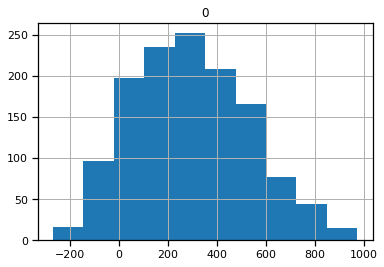

In [53]:
pd.DataFrame(y_predicted).hist()

 By applying all the features listed above, we can see that the model has improved significantly, however, from the distribution we can see that some of the y_predicted have negative value, meaning negative trips which does not make sense that needs to be excluded from the model calculation 

## Setting Negative Values to 0

In [54]:
linear_rmse = rmse(np.where(y_predicted<0, 0, y_predicted) - y_val)
print(linear_rmse)

226.26379632060926


## Time Series Cross Validation

In this section, since the dataset is time sensitive, we will use time series cross validation to our model, using both the simple model as well as the linear model

In [55]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

In [81]:
# this code is from assignment 6, except for TimeSeriesSplit

def cross_validate_rmse(model, X, y):
    
    # Setup
    model = clone(model)
    time_split = TimeSeriesSplit(n_splits=12) 
    rmse_values = []
    
    for train_index, val_index in time_split.split(X):
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        model.fit(X_train, y_train)
        y_predicted = model.predict(X_val)   
        
        
        rmse_values.append(rmse(y_predicted - y_val))
        
    return rmse_values

First applying on simple model 

In [82]:
simple_rmse_cv = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=x_train_simple, y=y_train_simple)
print('Cross-validation Simple RMSE scores: {}'.format(simple_rmse_cv))
print('Cross-validation Simple RMSE scores mean: {}'.format(np.mean(simple_rmse_cv)))
print('Cross-validation Simple RMSE scores std: {}'.format(np.std(simple_rmse_cv)))

Cross-validation Simple RMSE scores: [315.230212150544, 279.9860799202882, 293.563541776525, 323.1602475496827, 336.4595656806655, 299.40856947706874, 321.291658790099, 296.3434263164471, 374.71785770236045, 299.3348987962573, 318.8139209177943, 334.77133586896935]
Cross-validation Simple RMSE scores mean: 316.0901095788918
Cross-validation Simple RMSE scores std: 24.231877983836373


Next linear model is used 

In [83]:
linear_rmse_cv = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=x_train, y=y_train)
print('Cross-validation Linear RMSE scores: {}'.format(linear_rmse_cv))
print('Cross-validation Linear RMSE scores mean: {}'.format(np.mean(linear_rmse_cv)))
print('Cross-validation Linear RMSE scores std: {}'.format(np.std(linear_rmse_cv)))

Cross-validation Linear RMSE scores: [232.84655481744156, 201.39240779874635, 221.77277480803508, 223.8857921088316, 234.31471100916642, 221.1682377800556, 224.8477198097149, 222.46315815150487, 247.71445834898952, 211.85684560032172, 205.24914215284215, 219.66994685824736]
Cross-validation Linear RMSE scores mean: 222.26514577032478
Cross-validation Linear RMSE scores std: 12.09645305584364


The RMSE score from time series cross validation also confirms that our linear model performs well with an mean score of 222, we will use this to apply to our test dataset  

# Test Dataset 

Applying the model to test dataset as well as RMSE calculation with cross validation

In [69]:
x_train, y_train = process_data(train, ['Hour', 'Month'], ['Wind','Temp'], ['dow', 'Weather'])
x_test, y_test = process_data(test, ['Hour', 'Month'], ['Wind','Temp'], ['dow', 'Weather'])

In [80]:
linear_model = LinearRegression(fit_intercept=True)

linear_model.fit(x_train, y_train)

y_predicted = linear_model.predict(x_test)

linear_rmse_test = rmse(y_predicted - y_test)
print(linear_rmse_test)

226.03536567797323


In [89]:
def cross_validate_rmse_test(model, X, y):
    
    # Setup
    model = clone(model)
    time_split = TimeSeriesSplit(n_splits=12) 
    rmse_values = []
    
    for train_index, test_index in time_split.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        
        model.fit(X_train, y_train)
        y_predicted = model.predict(X_test)   
        
        
        rmse_values.append(rmse(y_predicted - y_test))
        
    return rmse_values

In [102]:
linear_rmse_cv_test = cross_validate_rmse_test(model=LinearRegression(fit_intercept=True), X=x_test, y=y_test)
print('Cross-validation Linear RMSE scores: {}'.format(linear_rmse_cv_test))
print('Cross-validation Linear RMSE scores mean: {}'.format(np.mean(linear_rmse_cv_test)))
print('Cross-validation Linear RMSE scores std: {}'.format(np.std(linear_rmse_cv_test)))

Cross-validation Linear RMSE scores: [214.8995346667833, 229.07343800624287, 255.020728630537, 223.20020861325375, 244.5512551721009, 237.87074221097473, 244.2523686873374, 233.45425809995413, 255.22239811583935, 229.29475571848562, 262.88836033571357, 229.12948440783435]
Cross-validation Linear RMSE scores mean: 238.23812772208808
Cross-validation Linear RMSE scores std: 13.828032866739447
